In [ ]:
#  from google.colab import files
# files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d soumikrakshit/div2k-high-resolution-images

In [ ]:
! pip install einops
import os
import cv2
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from einops import rearrange
import datetime
import torch.optim.lr_scheduler as lr_scheduler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 765.0 kB/s eta 0:00:00


In [ ]:

# import zipfile
# zip_file_path = '/content/div2k-high-resolution-images.zip'
# extracted_dir = '/content'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_dir)

In [ ]:
# import shutil
# source_folder = '/content/DIV2K_valid_HR/DIV2K_valid_HR'  # Change this to the path of your Colab folder
# destination_folder = '/content/drive/MyDrive/Training_model/dataset/val'  # Change this to the desired path in Google Drive

# shutil.copytree(source_folder, destination_folder)

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, div2k_path, noise_levels, patch_size):
#         self.image_list = []
#         self.noise_levels = noise_levels
#         self.patch_size = patch_size
#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#         ])

#         for i in os.listdir(div2k_path):
#             self.image_list.append(os.path.join(div2k_path, i))

#     def __len__(self):
#         return len(self.image_list)

#     def extract_patches(self, image):
#         h, w = image.shape[1], image.shape[2]
#         pad_h = (self.patch_size - (h % self.patch_size)) % self.patch_size
#         pad_w = (self.patch_size - (w % self.patch_size)) % self.patch_size

#         image = F.pad(image, (0, pad_w, 0, pad_h), mode='reflect')

#         unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
#         patches = unfold(image)
#         num_patches = patches.shape[-1]
#         patches = patches.view(3, self.patch_size, self.patch_size, num_patches)
#         patches = patches.permute(3, 0, 1, 2)
#         return patches

#     def __getitem__(self, idx):
#         img_path = self.image_list[idx]
#         hr_image = Image.open(img_path).convert('RGB')
#         hr_image = self.transform(hr_image)

#         sigma = np.random.choice(self.noise_levels)

#         noise = np.random.normal(0, sigma, hr_image.shape)

#         noisy_image = hr_image + torch.tensor(noise, dtype=torch.float32)
#         noisy_image = torch.clamp(noisy_image, 0, 1)

#         hr_image = self.extract_patches(hr_image)
#         noisy_image = self.extract_patches(noisy_image)

#         return noisy_image, hr_image

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, div2k_path, noise_levels, patch_size=None):
        self.image_list = []
        self.noise_levels = noise_levels
        self.patch_size = patch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        for i in os.listdir(div2k_path):
            self.image_list.append(os.path.join(div2k_path, i))

    def __len__(self):
        return len(self.image_list)

    def extract_patches(self, image):
        unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
        patches = unfold(image)
        num_patches = patches.shape[-1]
        patches = patches.view(3, self.patch_size, self.patch_size, num_patches)
        patches = patches.permute(3, 0, 1, 2)
        return patches

    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        hr_image = Image.open(img_path).convert('RGB')
        hr_image = self.transform(hr_image)

        sigma = np.random.choice(self.noise_levels)

        noise = np.random.normal(0, sigma, hr_image.shape)

        noisy_image = hr_image + torch.tensor(noise, dtype=torch.float32)
        noisy_image = torch.clamp(noisy_image, 0, 1)

        if self.patch_size is not None:
            hr_image = self.extract_patches(hr_image)
            noisy_image = self.extract_patches(noisy_image)

        return noisy_image, hr_image

In [ ]:
div2k_path = '/content/drive/MyDrive/Training_model/dataset/val'
noise_levels = [0.5, 1, 1.5, 2]
custom_dataset = CustomDataset(div2k_path, noise_levels)
dataloader = DataLoader(custom_dataset, shuffle=True)

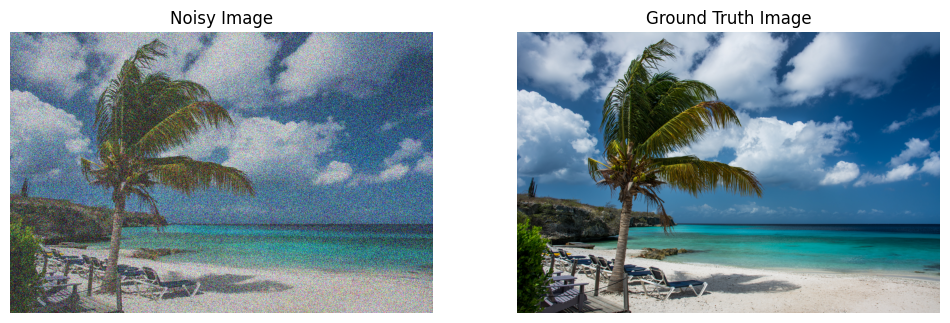

In [ ]:
sample = custom_dataset[0]
noise_image = sample[0]
hr_image = sample[1]

noisy_image = noise_image.permute(1, 2, 0).cpu().numpy()
ground_truth_image = hr_image.permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(noisy_image)
axes[0].set_title("Noisy Image")
axes[0].axis('off')

axes[1].imshow(ground_truth_image)
axes[1].set_title("Ground Truth Image")
axes[1].axis('off')

plt.show()

# Layer Normalization

In [ ]:
class LayerNormFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_tensors
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)

# Multi Dconv Head Transposed Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        b,c,h,w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q,k,v = qkv.chunk(3, dim=1)

        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)

        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        out = self.project_out(out)
        return out

# Simple Gate

In [ ]:
class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

# NAF Block

In [ ]:
class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, dropout_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel, bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.mdta = Attention(c, 8, True)
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c

        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(dropout_rate) if dropout_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate) if dropout_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, input):
        x = input

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.mdta(x)
        # x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = input + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

# U-Net Architecture

In [ ]:
class NAFNet(nn.Module):
    def __init__(self, img_channel=3, width=16, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[]):
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                nn.Conv2d(chan, 2*chan, 2, 2)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(chan, chan * 2, 1, bias=False),
                    nn.PixelShuffle(2)
                )
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x

In [ ]:
device = torch.device("cuda")

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
img_channel = 3
width = 32

enc_blks = [1, 1, 1, 28]
middle_blk_num = 1
dec_blks = [1, 1, 1, 1]

model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(device)

criterion = nn.MSELoss()
lr = 0.0001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [ ]:
def add_to_excelsheet( epoch_number, epoch_loss):
    excel_file_path = '/content/drive/MyDrive/Training_model/TrainingProgress/training_results_Denoise.xlsx'
    Epoch_number = epoch_number
    Epoch_loss = epoch_loss
    learning_rate = lr


    data = {'Epoch': [epoch_number], 'Loss': [epoch_loss], 'Learning Rate': [learning_rate]}
    df = pd.DataFrame(data)


    try:
        existing_df = pd.read_excel(excel_file_path)
        df = pd.concat([existing_df, df], ignore_index=True)
    except FileNotFoundError:
        pass


    with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='w') as writer:
        writer.book.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
        df.to_excel(writer, sheet_name='Sheet1', index=False)

In [ ]:
# epochs_loss = []
# num_epochs = 10
# with open("/content/drive/MyDrive/Training_model/training_progress_SIDD.txt", "w") as file:
#     for epoch in range(num_epochs):
#         batch_loss = []
#         for batch_no, (noisy_images, gt_images) in enumerate(dataloader):
#             patches_loss = []
#             for patch_index in range(noisy_images[0].size(0)):
#                 noisy_image = noisy_images[:, patch_index].to(device)
#                 gt_image = gt_images[:, patch_index].to(device)
#                 optimizer.zero_grad()
#                 outputs = model(noisy_image)
#                 loss = criterion(outputs, gt_image)
#                 loss.backward()
#                 optimizer.step()
#                 patches_loss.append(loss.item())
#                 progress_str = f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_no+1}/{len(dataloader)}], Patch [{patch_index+1}/{noisy_images[0].size(0)}], Loss: {loss.item()}"
#                 print(progress_str)
#                 file.write(progress_str + "\n")
#             batch_loss.append(sum(patches_loss) / len(patches_loss))
#         torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#             }, f"/content/drive/MyDrive/Training_model/nafnet_SIDD_epoch{epoch+1}.pth")
#         progress_str = f"Epoch [{epoch+1}/{num_epochs}], Epoch Loss: {sum(batch_loss) / len(batch_loss)}"
#         print(progress_str)
#         file.write(progress_str + "\n")
#         epochs_loss.append(sum(batch_loss) / len(batch_loss))
# file.close()

In [ ]:
folder = "/content/drive/MyDrive/Training_model"
checkpoint_path = f"{folder}/Div2k_epoch_44.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = int(checkpoint_path.split("/")[-1].split("_")[-1][:-4])
print(epoch)
i = 0
num_epochs = epoch + 2
with open(f"{folder}/TrainingProgress/training_progress_Div2k_{epoch+1}.txt", "w") as file:
    for epoch in range(epoch + 1, num_epochs):
        i = 0
        batch_loss = []
        for batch_no, (noisy_images, gt_images) in enumerate(dataloader):
            patches_loss = []
            for patch_index in range(noisy_images[0].size(0)):
                noisy_image = noisy_images[:, patch_index].to(device)
                gt_image = gt_images[:, patch_index].to(device)
                optimizer.zero_grad()
                outputs = model(noisy_image)
                loss = criterion(outputs, gt_image)
                loss.backward()
                optimizer.step()
                patches_loss.append(loss.item())
                progress_str = f"Epoch [{epoch}], Step [{batch_no+1}/{len(dataloader)}], Patch [{patch_index+1}/{noisy_images[0].size(0)}], Loss: {loss.item()}"
                print(progress_str)
                file.write(progress_str + "\n")
            batch_loss.append(sum(patches_loss) / len(patches_loss))
            i += 1
            if i % 100 == 0 and i != 0:
                torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                    }, f"{folder}/Div2k_epoch_{epoch}.pth")
                Epoch_loss = sum(batch_loss) / len(batch_loss)
                progress_str = f"Epoch [{epoch}], Epoch Loss: {Epoch_loss}"
                print(progress_str)
                file.write(progress_str + "\n")
        add_to_excelsheet(epoch, Epoch_loss)
file.close()

Streaming output truncated to the last 5000 lines.
Epoch [45], Step [10/800], Patch [4/6], Loss: 0.003119352739304304
Epoch [45], Step [10/800], Patch [5/6], Loss: 0.004343725275248289
Epoch [45], Step [10/800], Patch [6/6], Loss: 0.006007322110235691
Epoch [45], Step [11/800], Patch [1/9], Loss: 0.008396556600928307
Epoch [45], Step [11/800], Patch [2/9], Loss: 0.007993708364665508
Epoch [45], Step [11/800], Patch [3/9], Loss: 0.007357426919043064
Epoch [45], Step [11/800], Patch [4/9], Loss: 0.004615527577698231
Epoch [45], Step [11/800], Patch [5/9], Loss: 0.005629813298583031
Epoch [45], Step [11/800], Patch [6/9], Loss: 0.0047220797277987
Epoch [45], Step [11/800], Patch [7/9], Loss: 0.005838421173393726
Epoch [45], Step [11/800], Patch [8/9], Loss: 0.006158732809126377
Epoch [45], Step [11/800], Patch [9/9], Loss: 0.005195699632167816
Epoch [45], Step [12/800], Patch [1/6], Loss: 0.010169107466936111
Epoch [45], Step [12/800], Patch [2/6], Loss: 0.012201732955873013
Epoch [45], S

In [ ]:
from google.colab import runtime
runtime.unassign()

# Testing

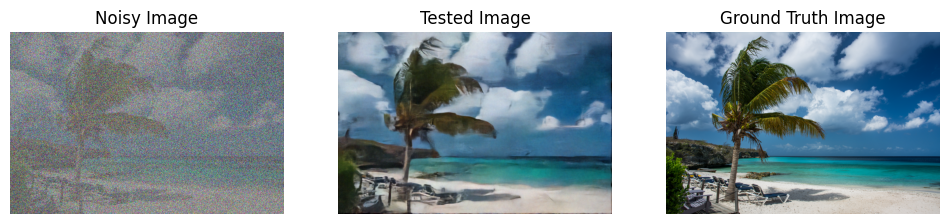

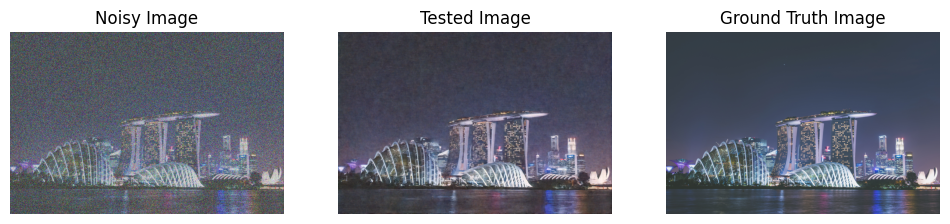

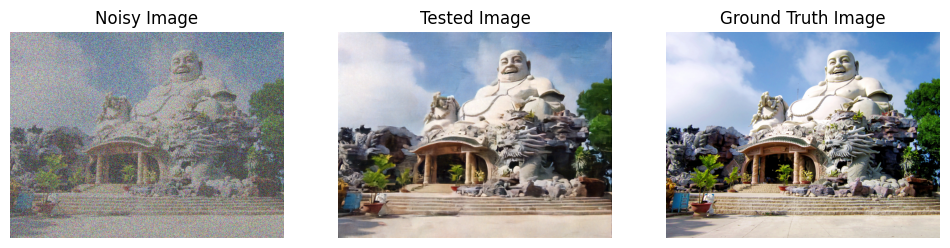

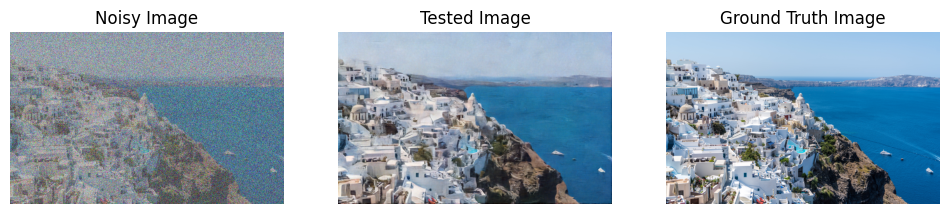

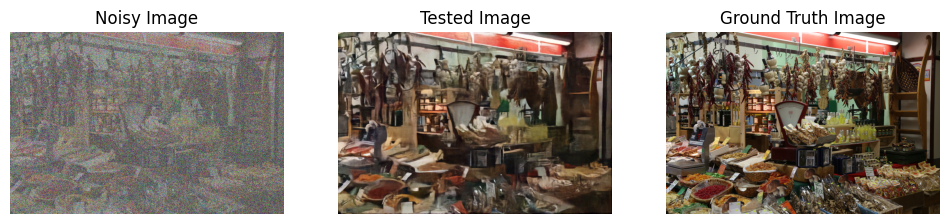

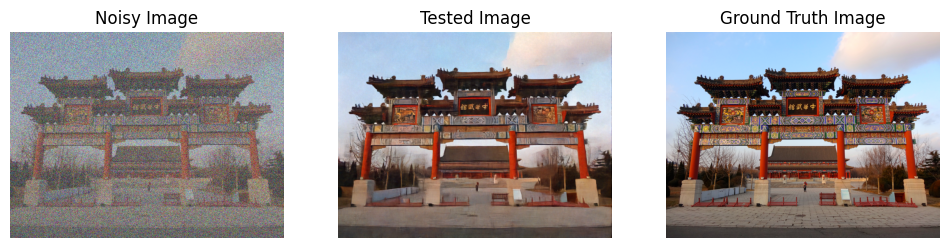

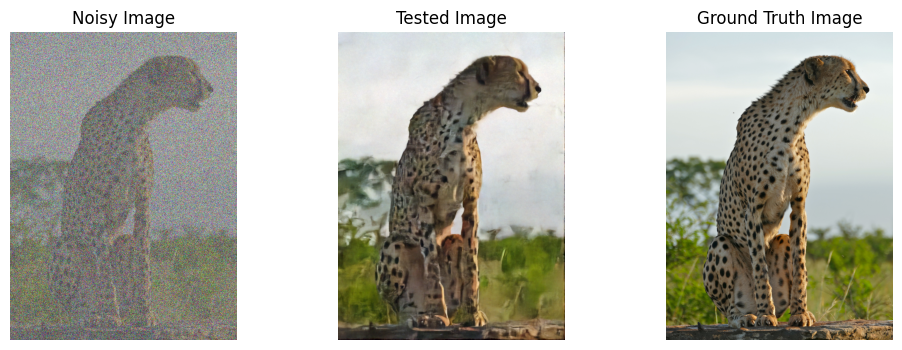

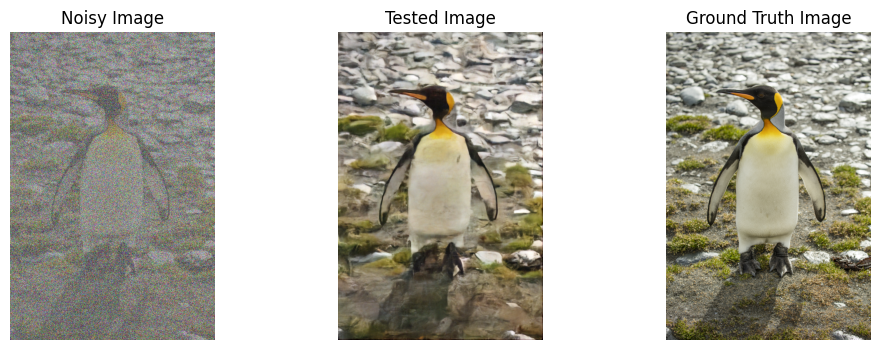

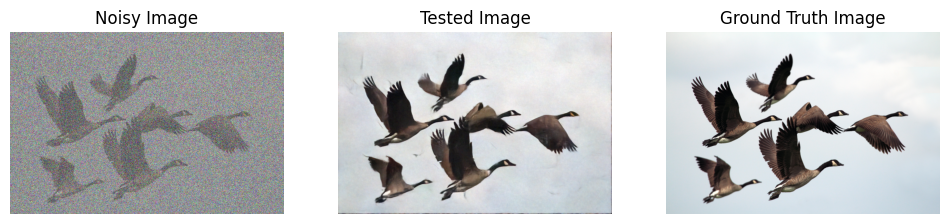

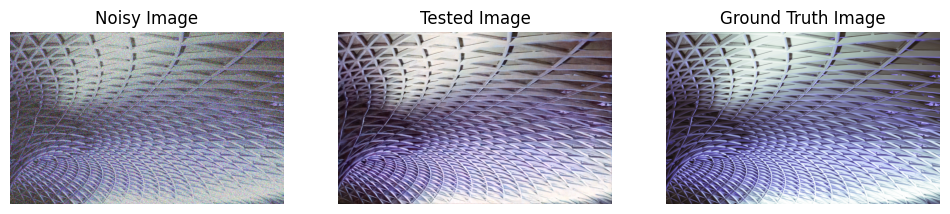

In [ ]:
img_channel = 3
width = 32

enc_blks = [1, 1, 1, 28]
middle_blk_num = 1
dec_blks = [1, 1, 1, 1]

test_model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(device)
optimizer = torch.optim.Adam(params=test_model.parameters(), lr=0.0001)

checkpoint_path = "/content/drive/MyDrive/Training_model/Div2k_epoch_45.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

test_model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

device = torch.device("cuda")

for i in range(0, len(custom_dataset), 10):
    test_model.eval()
    with torch.no_grad():
          noisy_image = custom_dataset[i][0].to(device)
          output = test_model(torch.unsqueeze(noisy_image, 0))
          image_np1 = noisy_image.to(device).permute(1, 2, 0).cpu().numpy()
          image_np2 = output[0].permute(1, 2, 0).cpu().numpy()
          image_np3 = custom_dataset[i][1].to(device).permute(1, 2, 0).cpu().numpy()

          fig, axes = plt.subplots(1, 3, figsize=(12, 4))

          axes[0].imshow(image_np1)
          axes[0].set_title("Noisy Image")
          axes[0].axis('off')

          axes[1].imshow(image_np2)
          axes[1].set_title("Tested Image")
          axes[1].axis('off')

          axes[2].imshow(image_np3)
          axes[2].set_title("Ground Truth Image")
          axes[2].axis('off')

          plt.savefig(f"/content/drive/MyDrive/Training_model/Denoised Images/{i}_45")

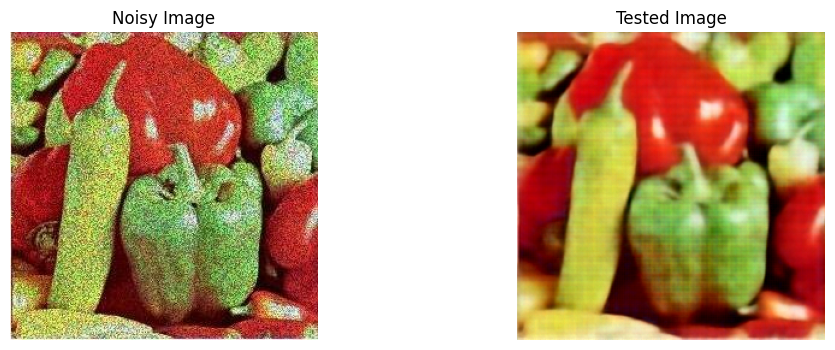

In [ ]:
img_channel = 3
width = 32

enc_blks = [1, 1, 1, 28]
middle_blk_num = 1
dec_blks = [1, 1, 1, 1]

test_model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(device)
optimizer = torch.optim.Adam(params=test_model.parameters(), lr=0.0001)

checkpoint_path = "/content/drive/MyDrive/Training_model/Div2k_epoch_45.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

test_model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

test_model.eval()
path = "/content/drive/MyDrive/Training_model/Samples/noisy_vegetables.jpg"
noisy_image = Image.open(path)
noisy_image = transforms.ToTensor()(noisy_image).to(device)
with torch.no_grad():
      output_chunk = test_model(torch.unsqueeze(noisy_image, 0))

image_np1 = noisy_image.permute(1, 2, 0).cpu().numpy()
image_np2 = output_chunk[0].permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(image_np1)
axes[0].set_title("Noisy Image")
axes[0].axis('off')

axes[1].imshow(image_np2)
axes[1].set_title("Tested Image")
axes[1].axis('off')
plt.savefig("/content/drive/MyDrive/Training_model/Denoised Images/noisy_vegetables_45.png")
plt.show()

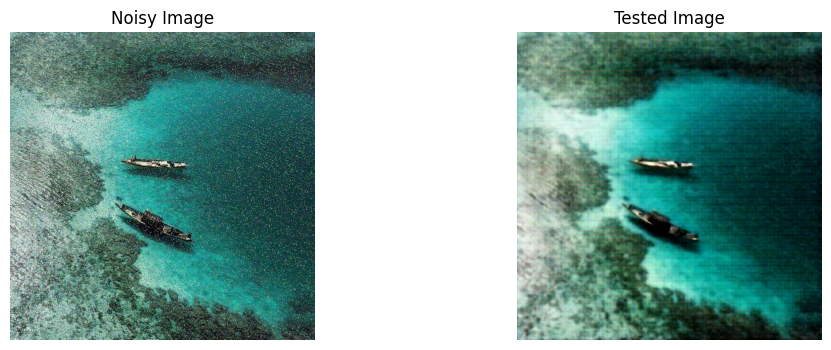

In [ ]:
import matplotlib.pyplot as plt
image_np1 = noisy_image.permute(1, 2, 0).cpu().numpy()
image_np2 = output_chunk[0].permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(image_np1)
axes[0].set_title("Noisy Image")
axes[0].axis('off')

axes[1].imshow(image_np2)
axes[1].set_title("Tested Image")
axes[1].axis('off')
# plt.savefig("/content/drive/MyDrive/Training_model/Test Progress/noisy_vegetables_epoch30.png")
plt.show()